In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math 
from scipy.integrate import odeint

In [93]:
# Exercise 1.1
beta = 0.3
gamma = 0.1
mu = 0.05
t = 200

def gillespies_sir(t, S0, I0, R0, beta, gamma, mu):
    times = []
    S_list = []
    I_list = []
    R_list = []
    
    t0 = 0
    S = S0
    I = I0
    R = R0

    while t0 < t and (S + I + R) > 0:
        N = S + I + R
        r_infect = beta * S * I / N
        r_birth = mu * N
        r_recover = gamma * I
        r_deathS = mu * S
        r_deathI = mu * I
        r_deathR = mu * R

        rate0 = r_infect + r_birth + r_recover + r_deathS + r_deathI + r_deathR

        if rate0 <= 0.0:
            break

        u1 = random.uniform(0, 1.0)
        dt = -math.log(u1) / rate0
        t0 += dt
        if t0 > t:
            break

        u2 = random.uniform(0, 1.0) * rate0
        if u2 < r_infect:
            if S > 0:
                S -= 1
                I += 1
        elif u2 < r_infect + r_birth:
            S += 1
        elif u2 < r_infect + r_birth + r_recover:
            if I > 0:
                I -= 1
                R += 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS:
            if S > 0:
                S -= 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS + r_deathI:
            if I > 0:
                I -= 1
        else:
            if R > 0:
                R -= 1   

        times.append(t0)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return times, S_list, I_list, R_list



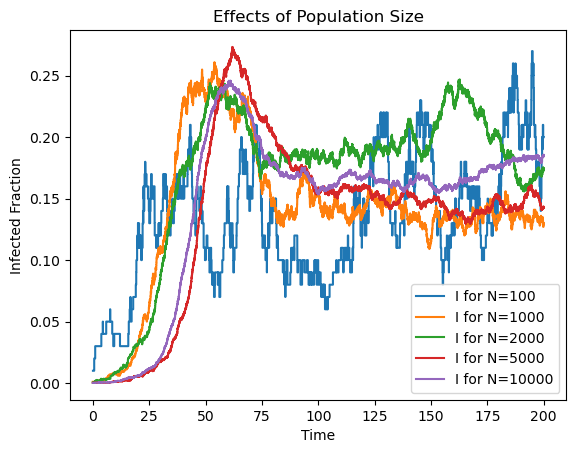

In [114]:
# PLotting:
N_vals = [100, 1000, 2000, 5000, 10000]


# Bonus part: controlling noise levels (somewhat?)
# Plot infected fractions for different values of N: more random for smaller N
for N in N_vals:
    S0, I0, R0 = N - 1, 1, 0
    times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
    fracI = np.array(I) / N # normalise since different Ns
    plt.step(times, fracI, where='post', label=f'I for N={N}')
    
plt.title('Effects of Population Size')
plt.xlabel('Time')
plt.ylabel('Infected Fraction')
plt.legend()
plt.show()



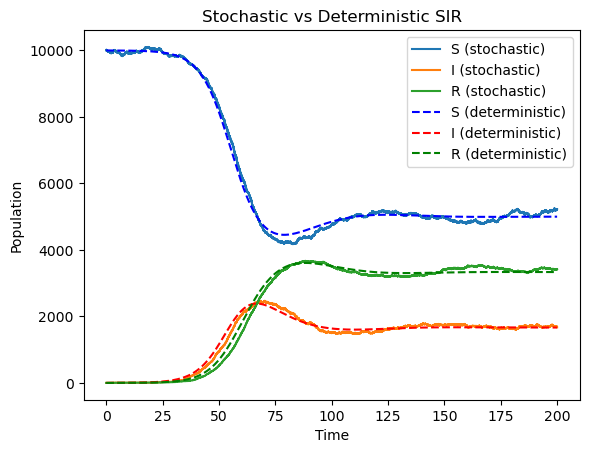

In [95]:
# Equivalent deterministic ODE:
def det_sir(y, t, beta, gamma, mu):
    S, I, R = y
    N = S + I + R
    dS = mu * N - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    return dS, dI, dR

def integrate_det_sir(y0, t, beta, gamma, mu):
    results = odeint(det_sir, y0, t, args=(beta, gamma, mu))
    S, I, R = results.T
    return S, I, R

# Plot together to compare:
plt.step(times, S_list, where='post', label='S (stochastic)')
plt.step(times, I_list, where='post', label='I (stochastic)')
plt.step(times, R_list, where='post', label='R (stochastic)')
S_det, I_det, R_det = integrate_det_sir([S0, I0, R0], times, beta, gamma, mu)
plt.plot(times, S_det, 'b--', label='S (deterministic)')
plt.plot(times, I_det, 'r--', label='I (deterministic)')
plt.plot(times, R_det, 'g--', label='R (deterministic)')
plt.title('Stochastic vs Deterministic SIR')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()
